# Butterfly Image Classification

I combine and improve this from the 87% project and the other one, which are:
1. https://www.kaggle.com/code/mcpenguin/butterfly-classification-efficientnet-87
2. https://github.com/lx9182/butterfly-image-classification

Today, we are going to do some steps to build an Image Classification Model using CNN that identifies the class which each butterfly belongs to:
1. The Data
2. Exploratory Data Analysis
3. Image Preprocessing
4. A basic CNN model
5. Transfer Learning with VGG16

# 1. The Data

The dataset is from [Kaggle - Butterfly Image Classification](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) which contains 6499 images belongs to 75 different classes of Butterflies. Each image belongs to only one butterfly category.
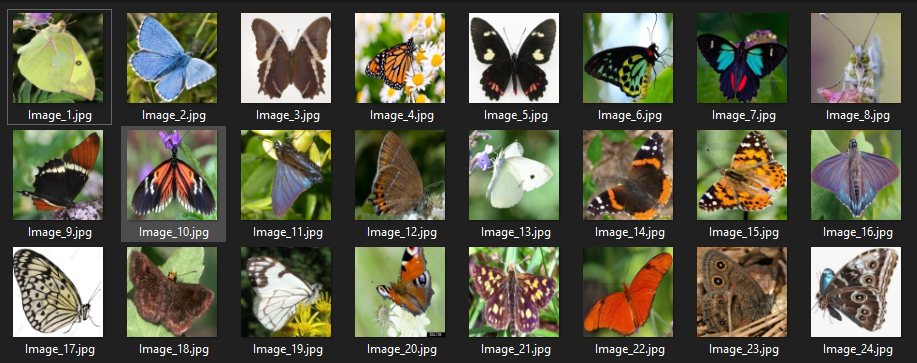

Also we have a csv file that contains label for each butterfly image. We will explore this in the next section.

In [ ]:
!pip install kaggle

!kaggle datasets download -d phucthaiv02/butterfly-image-classification

!unzip butterfly-image-classification.zip

# 2. Exploratory Data Analysis

**First we will explore the butterfly types from csv file**

In [1]:
# Should install tensorflow 2.15.0 
# because in 2.16.0 keras using 3.x.x which buggy when using tensorflow_hub
# !pip install tensorflow==2.15.0

In [1]:
!pip install -r requirements.txt

In [3]:
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import random

In [4]:
df = pd.read_csv('Training_set.csv')
df.head(5)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


**Do we have any missing values?**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB


**Yeah, we have full data.**

**Next let's check how many types of butterflies we got.**

In [6]:
len(df)

6499

**75 types as expected.**

**So what about the distribution for each butterfly types? This is so important because we will need a balance dataset for classification problem. Let's figure it out**

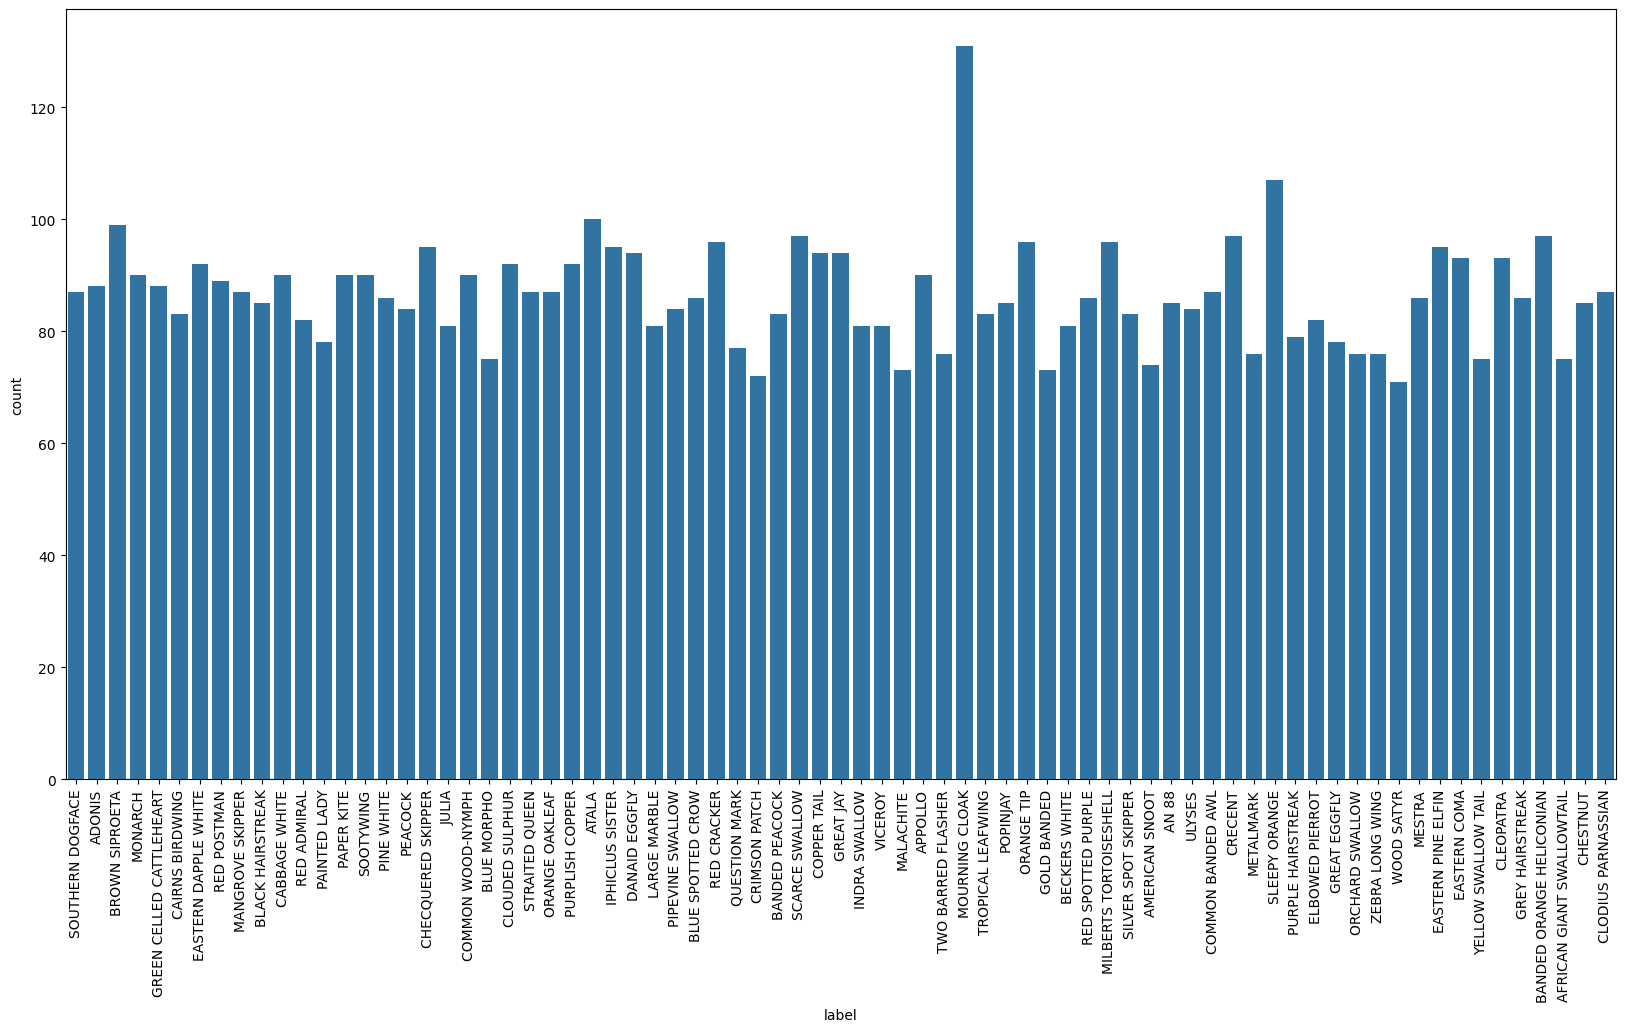

In [7]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
sns.countplot(data=df, x='label')
plt.show()

**Data seems quite balance, around 80 images for each butterfly class**

**Here are some sample images and its label:**

In [8]:
def show_random_images(folder_path, num_images, df):
    '''
    Show random images from a folder
    
    Input:
        folder_path: folder path
        num_images: number of images we want to display
        df: dataframe containing information of image and its label
    Output:
        None
    '''
    selected_images = random.sample(os.listdir(folder_path), num_images)
    fig, ax = plt.subplots(1, num_images, figsize=(15, 6))

    for i, image_name in enumerate(selected_images):
        image_path = os.path.join(folder_path, image_name)
        image = mpimg.imread(image_path)

        # Display the image
        ax[i].imshow(image)
        ax[i].axis('off')
        
        # Display the image name and label
        label = df.loc[df['filename'] == image_name, 'label'].values[0]
        ax[i].set_title(f'{image_name}\n{label}', fontsize=10)

    plt.tight_layout()
    plt.show()

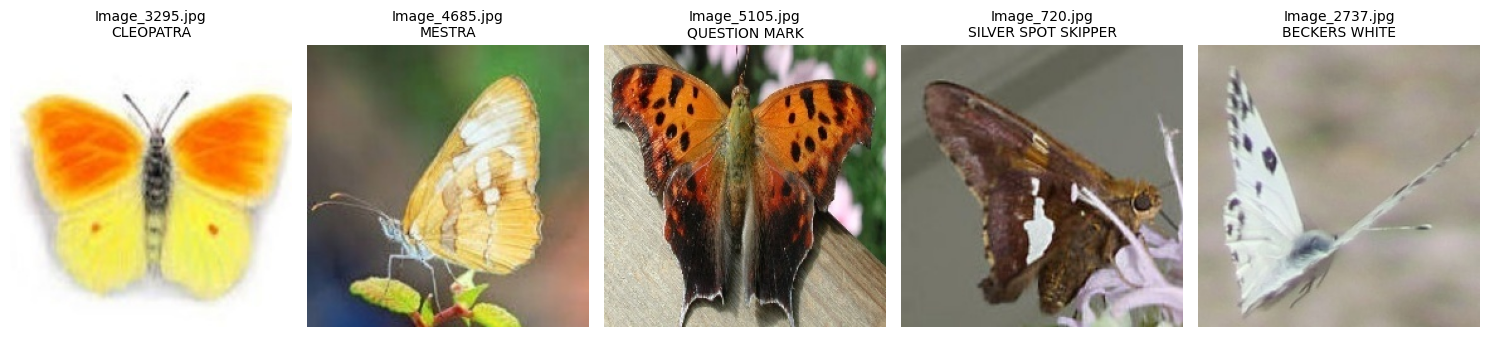

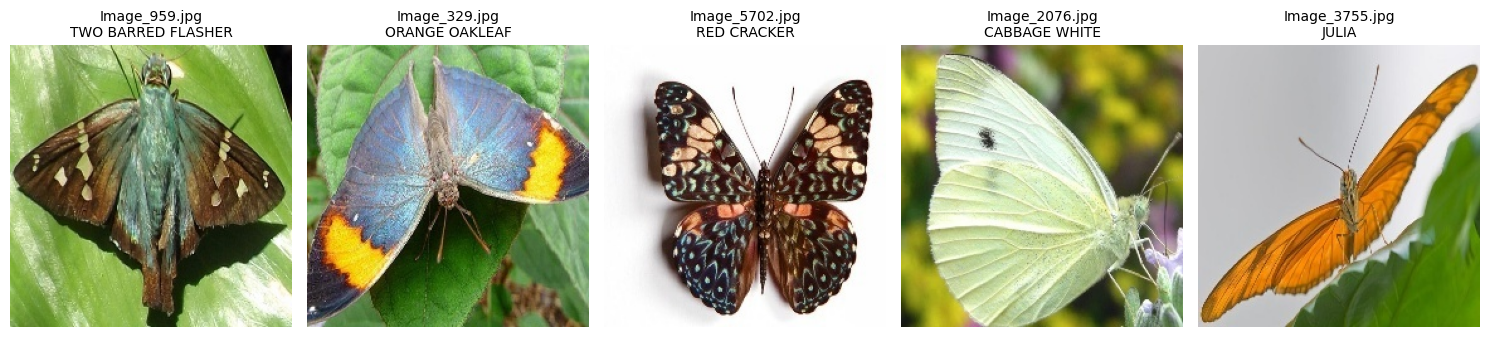

In [9]:
# Run this many times to see different images
show_random_images('train', 5, df)
show_random_images('train', 5, df)

# 3. Image Preprocessing

**Actually, the dataset is quite good that butterflies are focused and centered in the image. We just do normallize, resize and split data to train and validation/test before fit it to model in the next step.**

For the Image Augmentation (zoom, flip,..) we just left it for now. We can do it to improve model later.

In [10]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, Layer, BatchNormalization, ReLU, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-25 15:56:45.494021: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 15:56:45.522470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 15:56:45.522504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 15:56:45.523389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 15:56:45.528423: I tensorflow/core/platform/cpu_feature_guar

In [11]:
# Hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [12]:
# Define data generator for train and test dataset
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    df,
    directory='train',
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

test_generator = datagen.flow_from_dataframe(
    df,
    directory='train',
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.


**OK, now we have a cleaned train (5200 images) and test (1299 images) dataset. Let's go to the next step when we build and evaluate model.**

# 4. A basic CNN model

**Model architecture**

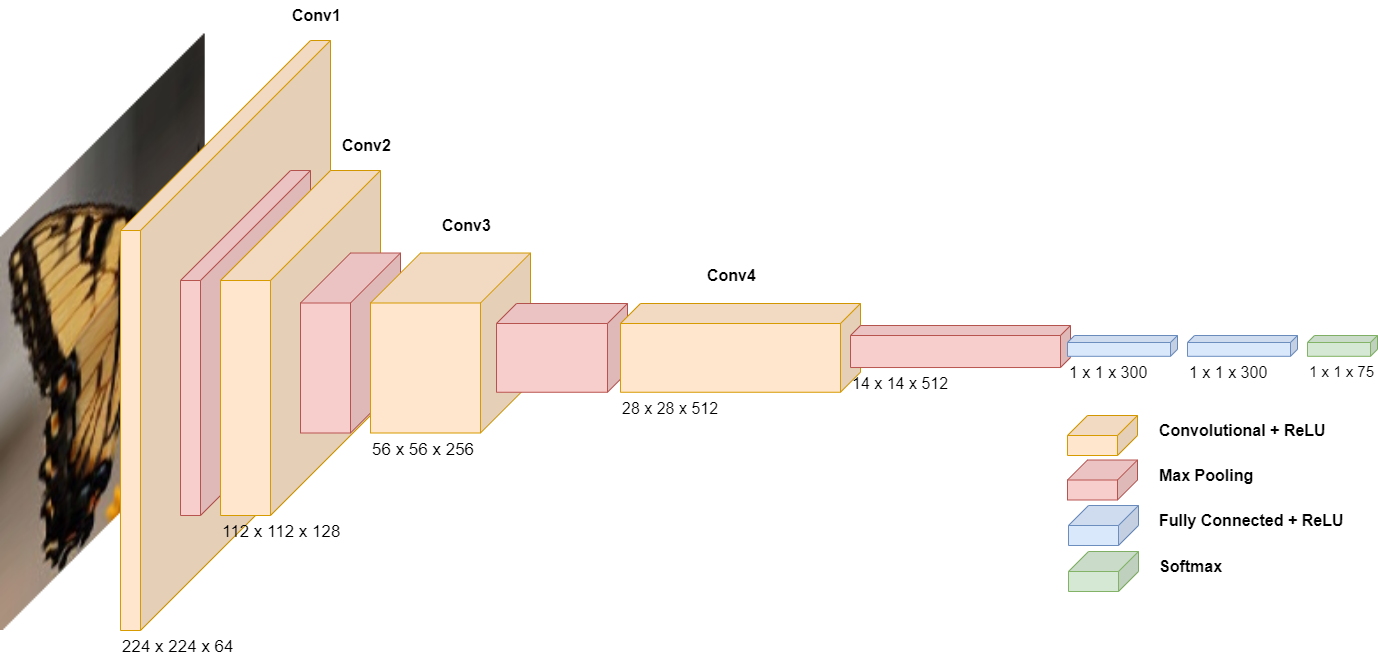

In [ ]:
import tensorflow as tf

import keras
from keras import layers, applications, optimizers

NUM_CLASSES = len(set(df['label'])) # there are actually 75 classes / labels

# Create model
def create_basic_cnn_model():

    model = keras.Sequential([])

    # Convolutional blocks
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dropout(0.4))

    # # Output layer
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    return model

model = create_basic_cnn_model()
model.summary()

### Instead of using our basic CNN model we used EfficientNet pretrained CNN architecture model

Here we implemented transfer learning

In [13]:
import tensorflow as tf
import tensorflow_hub as hub

import keras
from keras import layers, applications, optimizers

NUM_CLASSES = len(set(df['label'])) # there are actually 75 classes / labels

# Create model
def create_model():
    efficient_net = hub.KerasLayer(
        "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1",
        trainable=False,
        input_shape=(224,224,3)
    )

    model = keras.Sequential([
        efficient_net,
    ])

    # Freeze the pretrained weights
    # for layer in model.layers:
    #     layer.trainable = False

    # Convolutional blocks
    # model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    # model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    # model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    # model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    # model.add(layers.GlobalAveragePooling2D())
    # model.add(layers.Dropout(0.2))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dropout(0.5))

    # # Output layer
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    model.build([None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3])

    return model

model = create_model()
model.summary()

2024-06-25 15:57:08.001713: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 15:57:08.005968: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 15:57:08.006003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 15:57:08.007925: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 15:57:08.007964: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 dense (Dense)               (None, 300)               461100    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 75)                22575     
                                                                 
Total params: 13504597 (51.52 MB)
Trainable params: 5739

In [14]:
# Compile the model
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4),
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [15]:
import os; 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Disable warnings

# Get length of train 0.8 from total
STEPS_PER_EPOCH = int((len(df) * 0.8) // BATCH_SIZE)

# Train the model
history = model.fit(
    train_generator,
    epochs=22,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/22


2024-06-25 15:57:35.424306: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-06-25 15:57:47.913641: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f22b52f8d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-25 15:57:47.913688: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-25 15:57:48.094304: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719331068.532624     933 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 [==============================] - 104s 499ms/step - loss: 3.9775 - accuracy: 0.1087 - val_loss: 2.3723 - val_accuracy: 0.5350
Epoch 2/22
162/162 [==============================] - 21s 131ms/step - loss: 2.4194 - accuracy: 0.3777 - val_loss: 1.1315 - val_accuracy: 0.7821
Epoch 3/22
162/162 [==============================] - 21s 128ms/step - loss: 1.6485 - accuracy: 0.5395 - val_loss: 0.7239 - val_accuracy: 0.8253
Epoch 4/22
162/162 [==============================] - 21s 131ms/step - loss: 1.2617 - accuracy: 0.6428 - val_loss: 0.5396 - val_accuracy: 0.8568
Epoch 5/22
162/162 [==============================] - 21s 127ms/step - loss: 1.0105 - accuracy: 0.7038 - val_loss: 0.4952 - val_accuracy: 0.8630
Epoch 6/22
162/162 [==============================] - 22s 134ms/step - loss: 0.8867 - accuracy: 0.7382 - val_loss: 0.4341 - val_accuracy: 0.8799
Epoch 7/22
162/162 [==============================] - 22s 136ms/step - loss: 0.7776 - accuracy: 0.7712 - val_loss: 0.4044 - val_accuracy: 0.

***model training completed in 9 mins 19secs***

### **With 22 epochs, the training accuracy is around 90% and validation/test accuracy is also around 90%.**

**Training history:**

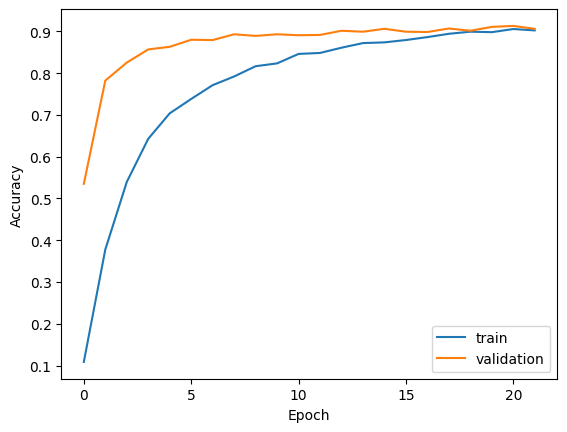

In [16]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

### Another Epochs

### **26 Epoch**

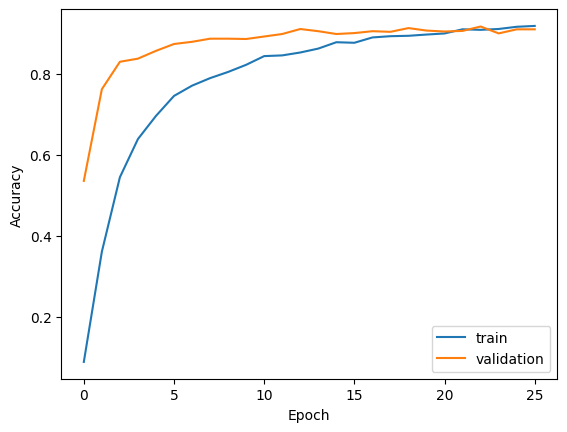

In [20]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

### **27 Epoch**

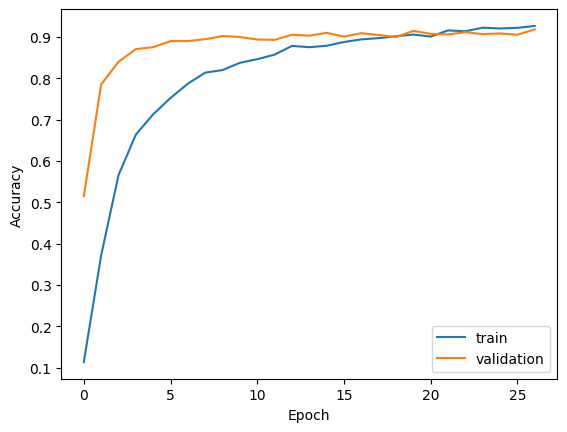

In [24]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()